In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
import glob
import math
from datetime import date
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': '16'})
import warnings; warnings.simplefilter('ignore')
# Load CUPY module
import cupy as cp

# GPU Parallelism

## CPU vs GPU

- CPU (Central Processing Unit) 
    - highly flexible computing elements, capable of doing any task required
    - Few very fast cores with large slow-access memory

- GPU (Graphics Processing Unit):
    - developed to handle very specific tasks, like ray-tracing and image rendering
    - 1000s of cores with small high-speed memory

- Some problems can be effectively split across the GPU cores for incredible speed-ups

## Vectorized Functions

- Vectorization: Applying the same function to every element of an array
- Example 1: Operate a function on each element of an array
- Example 2: matrix multiplication with large matrices (10k x 10k)


## GPUs on the Clusters

- We have a collection of GPUs available on Farnam and Grace
- Requesting these resources is straightforward ([YCRC docs](http://docs.ycrc.yale.edu/clusters-at-yale/job-scheduling/resource-requests/#request-gpus)), and only envolves adding a few flags to your `salloc` or `sbatch` commands:

`salloc --x11 -p gpu_devel -t 2:00:00 --gpus=1`

- This will request one GPU (a "general resource" or `gres`) from the `gpu_devel` partition
- Similar commands can be added to batch SLURM scripts and run on the `gpu` partition

## PyCUDA
_https://documen.tician.de/pycuda/_

- Python connection to NVIDIA's CUDA GPU framework
- Low-level code written in C++, but all the mess is abstracted away
- Still rather complex to work with, but very powerful

## Cupy

_https://docs-cupy.chainer.org/en/stable/_

- Drop-in replacement for numpy (fully compatible API)
- Allows for near seamless GPU-based computation 
- Matrix multiplication, vector operations, etc.

Easily installed via `conda` after loading the `CUDA` module on the clusters


In [2]:
# Load CUPY module
import cupy as cp

First, let's define a test routine with `numpy`

In [3]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Matrix Mult
out = np.matmul(a,b)


2.71 s ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now, let's perform the same code but running the multiplication on the GPU

In [4]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Move to GPU
g = cp.asarray(a)
h = cp.asarray(b)

# Matrix Mult
out = cp.matmul(g,h)

290 ms ± 138 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Considerablly faster matrix multiplication without any complicated parallel work!

## Example 4: NYC Taxi Cab Data (again)

### Load data using Pandas
Pandas has very friendly tools for reading data, we will use the `read_csv` method to read our Taxi Cab data before converting it to numpy arrays

In [5]:
january = pd.read_parquet('../taxi/yellow_tripdata_2022-01.parquet')
july = pd.read_parquet('../taxi/yellow_tripdata_2022-07.parquet')

In [6]:
tip_jan = np.array(january['tip_amount'])
distance_jan = np.array(january['trip_distance'])

tip_jul = np.array(july['tip_amount'])
distance_jul = np.array(july['trip_distance'])

### Move data to GPU

Cupy has built-in tools to move data to and from GPUs, `cp.asarray()` and `cp.asnumpy`. We will use these to analyze data from the Taxi Cab dataset.

In [7]:
gpu_tip_jan = cp.asarray(tip_jan)
gpu_dist_jan = cp.asarray(distance_jan)

gpu_tip_jul = cp.asarray(tip_jul)
gpu_dist_jul = cp.asarray(distance_jul)

### Comparison of CPU and GPU performance

In [8]:
%%timeit
np.divide(tip_jan, distance_jan)

2.57 ms ± 25.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit 
gpu_tip_per_mile = cp.divide(gpu_tip_jan, gpu_dist_jan)

78.3 μs ± 0.721 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Visualizing Results

Data have to be pulled off the GPU to be able to visualize them. 

January Average: 1.219
July Average: 1.211


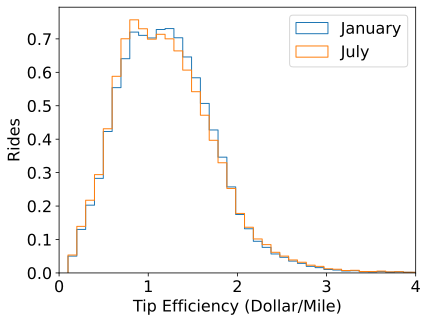

In [10]:
gpu_tip_per_mile = cp.divide(gpu_tip_jan, gpu_dist_jan)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_jan > 0) & (distance_jan > 1)]

plt.hist(tpm, bins=100, range=(0.1,10), histtype='step', label='January',density=True);
print(f'January Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

gpu_tip_per_mile = cp.divide(gpu_tip_jul, gpu_dist_jul)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_jul > 0) & (distance_jul > 1)]

plt.hist(tpm, bins=100, range=(0.1,10), histtype='step', label='July',density=True);
print(f'July Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

plt.xlabel('Tip Efficiency (Dollar/Mile)');plt.ylabel('Rides');plt.legend();
plt.xlim(0,4);

## GPU Summary

- There are a ton of exciting projects that are starting to utilize GPUs. 
- Having python connection to these tools enable rapid work with machine learning or other computationally intensive tasks
- Make use of the GPUs in the clusters to get started with this kind of tool